In [171]:
import os, torch, pandas as pd, numpy as np, matplotlib.pyplot as plt
from torch import nn
from torch.nn import Linear, ReLU, Sequential
from torch_geometric.nn import NNConv

import geopandas as gpd
from shapely.geometry import Point
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

In [172]:
NODES_EPSG = 5179
# ---------- paths ----------
CLIMATE_URBAN = r"D:/Desktop/MSc Thesis/Results/models/gnn_climate_urban.pth"
CLIMATE = r"D:/Desktop/MSc Thesis/Results/models/gnn_climate.pth"
BASELINE = r"D:/Desktop/MSc Thesis/Results/models/gnn_baseline.pth"

ART_CLIMATE_URBAN  = r"D:/Desktop/MSc Thesis/Results/models/gnn_climate_urban_dataset_artifacts.pt"
ART_CLIMATE       = r"D:/Desktop/MSc Thesis/Results/models/gnn_climate_dataset_artifacts.pt"
ART_BASELINE      = r"D:/Desktop/MSc Thesis/Results/models/gnn_baseline_dataset_artifacts.pt"

NODES_CSV = r"D:/Desktop/MSc Thesis - Copy/shapefiles/_network_parts_4_intersections/node_urban_features.csv"
OUT_DIR   = r"D:/Desktop/MSc Thesis/Results/interval_maps"
SCENARIO_DIR = r"D:/Desktop/MSc Thesis - Copy/Results/scenarios"

In [ ]:
RIVER_SHP = r"D:/Desktop/MSc Thesis - Copy/Data/GIS data/Water/seoulsanlimwater.shp"

In [173]:
INTERVALS = [
    (8, 10),   # 08:00–10:00
    (12, 14),  # 12:00–14:00
    (16, 18),  # 16:00–18:00
    (18, 20),  # 18:00–20:00
]

In [174]:
# ---------- model definition (matches training) ----------
class EdgeAwareTemporalEncoder(nn.Module):
    def __init__(self, in_channels, edge_feat_dim, hidden_dim):
        super().__init__()
        self.edge_nn = Sequential(Linear(edge_feat_dim, 32), ReLU(), Linear(32, in_channels * hidden_dim))
        self.conv = NNConv(in_channels=in_channels, out_channels=hidden_dim, nn=self.edge_nn, aggr='mean')
        self.gru  = nn.GRUCell(hidden_dim, hidden_dim)

    def forward(self, x_seq, edge_index_seq, edge_attr_seq):
        h = None
        for x, ei, ea in zip(x_seq, edge_index_seq, edge_attr_seq):
            out = self.conv(x, ei, ea)
            h = out if h is None else self.gru(out, h)
        return h

class MovementLinkPredictor(nn.Module):
    def __init__(self, in_channels, encoder_edge_feat_dim, time_feat_dim, hidden_dim):
        super().__init__()
        self.encoder = EdgeAwareTemporalEncoder(in_channels, encoder_edge_feat_dim, hidden_dim)
        self.node_decoder = nn.Sequential(Linear(hidden_dim + time_feat_dim, 64), ReLU(), Linear(64, 1))

    def forward_encoder(self, x_seq, edge_index_seq, edge_attr_seq):
        return self.encoder(x_seq, edge_index_seq, edge_attr_seq)

    def predict_node_counts(self, z, time_feat):
        return self.node_decoder(torch.cat([z, time_feat], dim=1)).squeeze(1)


In [175]:
# ---------- helpers ----------
@torch.no_grad()
def predict_nodes_for_bins(model, features, edge_indices, edge_features, targets, bins, bin_context, window_size):
    rows, N = [], features[0].shape[0]
    model.eval()
    for t in bins:
        if t < window_size:
            continue
        if all(ei.size(1) == 0 for ei in edge_indices[t-window_size:t]):
            continue
        z = model.forward_encoder(features[t-window_size:t], edge_indices[t-window_size:t], edge_features[t-window_size:t])
        h_norm, d_norm = bin_context[t]
        node_time = torch.tensor([[h_norm, d_norm]], dtype=torch.float).repeat(N, 1)
        pred = model.predict_node_counts(z, node_time)
        for nid in range(N):
            rows.append({"time_bin": int(t), "node_id": int(nid), "pred_count": float(pred[nid].item())})
    return pd.DataFrame(rows)

def _ensure_datetime_columns(bin_context, start_time_dt, interval):
    """Return a dict t->(dt, hour, dow) using real timestamps when available; fallback to normalized."""
    meta = {}
    for t, (h_norm, d_norm) in bin_context.items():
        if (start_time_dt is not None) and (interval is not None):
            dt = start_time_dt + pd.Timedelta(seconds=int(interval) * t) + pd.Timedelta(seconds=int(interval)//2)
            hour = dt.hour + dt.minute / 60.0
            dow  = dt.dayofweek  # Mon=0..Sun=6
            meta[int(t)] = (dt, hour, dow)
        else:
            hour = 23.0 * float(h_norm)
            dow  = int(round(6.0 * float(d_norm)))
            meta[int(t)] = (None, hour, dow)
    return meta

def select_bins_by_days_and_hours(bin_context, start_time_dt, interval, day_selector, hour_range_list, weekdays_only=False):
    """
    day_selector:
      - None -> all days
      - list/iterable of 'YYYY-MM-DD' strings
      - tuple ('YYYY-MM-DD', 'YYYY-MM-DD') inclusive range
    hour_range_list: list of (start_hour, end_hour) with end exclusive
    """
    meta = _ensure_datetime_columns(bin_context, start_time_dt, interval)

    allowed_dates = None
    if day_selector is None:
        allowed_dates = None
    else:
        if isinstance(day_selector, (list, tuple, set)) and not (isinstance(day_selector, tuple) and len(day_selector) == 2):
            allowed_dates = set(pd.to_datetime(d).date() for d in day_selector)
        elif isinstance(day_selector, tuple) and len(day_selector) == 2:
            d0 = pd.to_datetime(day_selector[0]).date()
            d1 = pd.to_datetime(day_selector[1]).date()
            allowed_dates = set(pd.date_range(d0, d1, freq="D").date)
        else:
            allowed_dates = {pd.to_datetime(day_selector).date()}

    out = []
    for t, (dt, hour, dow) in meta.items():
        if weekdays_only and dow is not None and dow > 4:
            continue
        if allowed_dates is not None and dt is not None:
            if dt.date() not in allowed_dates:
                continue
        if any(h0 <= hour < h1 for (h0, h1) in hour_range_list):
            out.append(t)
    return sorted(set(out))

def aggregate(pred_df, how="mean"):
    g = pred_df.groupby("node_id")["pred_count"]
    if how == "mean":
        res = g.mean()
    elif how == "peak":
        res = g.max()
    else:
        raise ValueError("how must be 'mean' or 'peak'")
    return res.reset_index().rename(columns={"pred_count":"value"})


In [176]:
# ---------- GeoPandas-based plotting (keeps projection/aspect) ----------

def plot_grid_2x4_gpd(nodes_gdf, mean_dfs, peak_dfs, titles_row1, titles_row2, out_path,
                      vmin_row1=None, vmax_row1=None, vmin_row2=None, vmax_row2=None,
                      zero_cutoff=0.0, cmap="viridis", show=True):
    """
    nodes_gdf: GeoDataFrame with columns [node_id, geometry] and projected CRS (e.g., EPSG:5179)
    mean_dfs / peak_dfs: list of 4 DataFrames each, with columns [node_id, value]
    """
    assert len(mean_dfs) == len(peak_dfs) == 4, "Expect 4 intervals for each row"

    # Merge values into GeoDataFrames
    merged_mean = [nodes_gdf.merge(df, on="node_id", how="left") for df in mean_dfs]
    merged_peak = [nodes_gdf.merge(df, on="node_id", how="left") for df in peak_dfs]

    # Compute shared color limits per row if not given
    if vmin_row1 is None or vmax_row1 is None:
        vals = pd.concat([m["value"].dropna() for m in merged_mean], axis=0) if any("value" in m for m in merged_mean) else pd.Series([0.0, 1.0])
        vmin_row1 = float(vals.min()) if len(vals) else 0.0
        vmax_row1 = float(vals.max()) if len(vals) else 1.0
    if vmin_row2 is None or vmax_row2 is None:
        vals = pd.concat([p["value"].dropna() for p in merged_peak], axis=0) if any("value" in p for p in merged_peak) else pd.Series([0.0, 1.0])
        vmin_row2 = float(vals.min()) if len(vals) else 0.0
        vmax_row2 = float(vals.max()) if len(vals) else 1.0

    norm1 = Normalize(vmin=vmin_row1, vmax=vmax_row1)
    norm2 = Normalize(vmin=vmin_row2, vmax=vmax_row2)

    # -------- NEW LAYOUT: 2 rows × 5 columns (last col is for colorbars) --------
    fig = plt.figure(figsize=(18, 8))
    gs = fig.add_gridspec(nrows=2, ncols=5, width_ratios=[1, 1, 1, 1, 0.035],
                          wspace=0.05, hspace=0.25)

    axes = np.empty((2, 4), dtype=object)
    for r in range(2):
        for c in range(4):
            axes[r, c] = fig.add_subplot(gs[r, c])

    # Dedicated colorbar axes (one per row)
    cax1 = fig.add_subplot(gs[0, 4])
    cax2 = fig.add_subplot(gs[1, 4])

    # ---- Row 1: mean ----
    for ax, gdf_i, title in zip(axes[0], merged_mean, titles_row1):
        # Optional zero masking
        if zero_cutoff > 0:
            zero = gdf_i[gdf_i["value"].fillna(0) <= zero_cutoff]
            pos  = gdf_i[gdf_i["value"].fillna(0) >  zero_cutoff]
            if len(zero):
                zero.plot(ax=ax, color="white", edgecolor='k', linewidth=0.1, markersize=8)
        else:
            pos = gdf_i

        if len(pos):
            pos_sorted = pos.sort_values("value")
            pos_sorted.plot(ax=ax, column="value", cmap=cmap, markersize=8,
                     edgecolor='k', linewidth=0.3,
                     vmin=vmin_row1, vmax=vmax_row1, legend=False)
        ax.set_title(title, pad=10)   # <-- add padding to avoid overlap
        ax.set_axis_off()

    # Row 1 colorbar in its own axis
    sm1 = ScalarMappable(norm=norm1, cmap=cmap); sm1.set_array([])
    cbar1 = fig.colorbar(sm1, cax=cax1)
    cbar1.set_label("Mean predicted value")

    # ---- Row 2: peak ----
    for ax, gdf_i, title in zip(axes[1], merged_peak, titles_row2):
        if zero_cutoff > 0:
            zero = gdf_i[gdf_i["value"].fillna(0) <= zero_cutoff]
            pos  = gdf_i[gdf_i["value"].fillna(0) >  zero_cutoff]
            if len(zero):
                zero.plot(ax=ax, color="white", edgecolor='k', linewidth=0.1, markersize=8)
        else:
            pos = gdf_i

        if len(pos):
            pos_sorted = pos.sort_values("value")
            pos_sorted.plot(ax=ax, column="value", cmap=cmap, markersize=8,
                     edgecolor='k', linewidth=0.3,
                     vmin=vmin_row2, vmax=vmax_row2, legend=False)
        ax.set_title(title, pad=10)   # <-- add padding to avoid overlap
        ax.set_axis_off()

    # Row 2 colorbar in its own axis
    sm2 = ScalarMappable(norm=norm2, cmap=cmap); sm2.set_array([])
    cbar2 = fig.colorbar(sm2, cax=cax2)
    cbar2.set_label("Peak predicted value")

    # Spacing: leave room for the suptitle and avoid overlaps
    fig.suptitle("Predicted Node Values — Row 1: Mean, Row 2: Peak", y=0.98)
    fig.tight_layout(rect=[0, 0, 0.98, 0.94])

    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=250)
        print(f"Saved figure → {out_path}")
    if show:
        plt.show()
    plt.close(fig)
    return fig, axes


In [177]:
# # OLD ---------- load artifacts & checkpoint ----------
# def _load_everything():
#     art = torch.load(ART, map_location="cpu")

#     features      = art["features"]
#     edge_indices  = art["edge_indices"]
#     edge_features = art["edge_features"]
#     targets       = art.get("targets", None)
#     bin_context   = art["bin_context"]
#     window_size   = art.get("window_size", 5)
#     start_time_dt = art.get("start_time_dt", None)
#     interval      = art.get("interval", None)

#     ckpt = torch.load(CKPT, map_location="cpu")
#     in_channels = features[0].shape[1]
#     hidden_dim  = ckpt.get("config", {}).get("embedding_dim", 64)
#     encoder_edge_feat_dim = 4  # (as in training)
#     time_feat_dim = 2          # hour_norm, day_norm

#     model = MovementLinkPredictor(
#         in_channels=in_channels,
#         encoder_edge_feat_dim=encoder_edge_feat_dim,
#         time_feat_dim=time_feat_dim,
#         hidden_dim=hidden_dim
#     )
#     state = ckpt["model_state"]
#     current = model.state_dict()
#     filtered = {k: v for k, v in state.items() if k in current and current[k].shape == v.shape}
#     model.load_state_dict(filtered, strict=False)
#     model.eval()

#     # --- GeoDataFrame for nodes (already in Korean CRS) ---
#     nodes_df = pd.read_csv(NODES_CSV) if os.path.exists(NODES_CSV) else None
#     if nodes_df is None:
#         print("! nodes CSV not found; plotting will be skipped.")
#         nodes_gdf = None
#     else:
#         # Expect columns: node_id, node_x, node_y already in projected CRS
#         nodes_gdf = gpd.GeoDataFrame(
#             nodes_df.copy(),
#             geometry=gpd.points_from_xy(nodes_df["node_x"], nodes_df["node_y"]),
#             crs=f"EPSG:{NODES_EPSG}"
#         )

#     return dict(model=model, features=features, edge_indices=edge_indices, edge_features=edge_features,
#                 targets=targets, bin_context=bin_context, window_size=window_size,
#                 start_time_dt=start_time_dt, interval=interval, nodes_gdf=nodes_gdf)


In [178]:
def _load_everything(
    ckpt_path=None,
    art_path=None,
    nodes_csv_path=None,
    nodes_epsg=NODES_EPSG,
):
    """
    Loads artifacts, checkpoint, and nodes. If a path is None, falls back to the
    module-level defaults (CKPT, ART, NODES_CSV).
    """
    # ckpt_path     = ckpt_path     or CKPT
    # art_path      = art_path      or ART
    nodes_csv_path = nodes_csv_path or NODES_CSV

    art = torch.load(art_path, map_location="cpu")

    features      = art["features"]
    edge_indices  = art["edge_indices"]
    edge_features = art["edge_features"]
    targets       = art.get("targets", None)
    bin_context   = art["bin_context"]
    window_size   = art.get("window_size", 5)
    start_time_dt = art.get("start_time_dt", None)
    interval      = art.get("interval", None)

    ckpt = torch.load(ckpt_path, map_location="cpu")
    in_channels = features[0].shape[1]
    hidden_dim  = ckpt.get("config", {}).get("embedding_dim", 64)
    encoder_edge_feat_dim = 4  # (as in training)
    time_feat_dim = 2          # hour_norm, day_norm

    model = MovementLinkPredictor(
        in_channels=in_channels,
        encoder_edge_feat_dim=encoder_edge_feat_dim,
        time_feat_dim=time_feat_dim,
        hidden_dim=hidden_dim
    )
    state = ckpt["model_state"]
    current = model.state_dict()
    filtered = {k: v for k, v in state.items() if k in current and current[k].shape == v.shape}
    model.load_state_dict(filtered, strict=False)
    model.eval()

    # --- GeoDataFrame for nodes ---
    if (nodes_csv_path is None) or (not os.path.exists(nodes_csv_path)):
        print("! nodes CSV not found; plotting will be skipped.")
        nodes_gdf = None
    else:
        nodes_df = pd.read_csv(nodes_csv_path)
        nodes_gdf = gpd.GeoDataFrame(
            nodes_df.copy(),
            geometry=gpd.points_from_xy(nodes_df["node_x"], nodes_df["node_y"]),
            crs=f"EPSG:{nodes_epsg}"
        )

    return dict(model=model, features=features, edge_indices=edge_indices, edge_features=edge_features,
                targets=targets, bin_context=bin_context, window_size=window_size,
                start_time_dt=start_time_dt, interval=interval, nodes_gdf=nodes_gdf)


In [179]:
# # OLD ---------- main callable ----------
# def generate_interval_maps(
#     day_selector=None,
#     weekdays_only=False,
#     zero_cutoff=0.0,
#     cmap="viridis",
#     save_prefix="interval_maps"
# ):
#     """
#     Create 8 maps:
#       Row 1: mean across chosen portion for each interval.
#       Row 2: peak (max) across chosen portion for each interval.
#     """
#     os.makedirs(OUT_DIR, exist_ok=True)

#     env = _load_everything()
#     model         = env["model"]
#     features      = env["features"]
#     edge_indices  = env["edge_indices"]
#     edge_features = env["edge_features"]
#     bin_context   = env["bin_context"]
#     window_size   = env["window_size"]
#     start_time_dt = env["start_time_dt"]
#     interval      = env["interval"]
#     nodes_gdf     = env["nodes_gdf"]

#     # Prepare one prediction DF per interval
#     interval_bins_list = []
#     for h0, h1 in INTERVALS:
#         bins = select_bins_by_days_and_hours(
#             bin_context=bin_context,
#             start_time_dt=start_time_dt,
#             interval=interval,
#             day_selector=day_selector,
#             hour_range_list=[(h0, h1)],
#             weekdays_only=weekdays_only
#         )
#         interval_bins_list.append(bins)
#         print(f"Interval {h0:02d}-{h1:02d}: selected bins = {len(bins)}")

#     pred_dfs = []
#     for bins in interval_bins_list:
#         if len(bins) == 0:
#             pred_dfs.append(pd.DataFrame(columns=["time_bin","node_id","pred_count"]))
#             continue
#         pred_df = predict_nodes_for_bins(
#             model, features, edge_indices, edge_features, targets=None,
#             bins=bins, bin_context=bin_context, window_size=window_size
#         )
#         pred_dfs.append(pred_df)

#     # Aggregations
#     mean_dfs = [aggregate(df, how="mean") if not df.empty else pd.DataFrame(columns=["node_id","value"]) for df in pred_dfs]
#     peak_dfs = [aggregate(df, how="peak") if not df.empty else pd.DataFrame(columns=["node_id","value"]) for df in pred_dfs]

#     # Save CSVs (one mean + one peak per interval)
#     tag = "alldays" if day_selector is None else "subset"
#     for (h0,h1), mdf, pdf in zip(INTERVALS, mean_dfs, peak_dfs):
#         mpath = os.path.join(OUT_DIR, f"{save_prefix}_mean_{h0:02d}-{h1:02d}_{tag}.csv")
#         ppath = os.path.join(OUT_DIR, f"{save_prefix}_peak_{h0:02d}-{h1:02d}_{tag}.csv")
#         mdf.to_csv(mpath, index=False); print(f"Saved → {mpath}")
#         pdf.to_csv(ppath, index=False); print(f"Saved → {ppath}")

#     if nodes_gdf is None:
#         print("Nodes file missing; skipping map rendering.")
#         return

#     # Titles per subplot
#     titles_row1 = [f"Mean {h0:02d}:00–{h1:02d}:00" for (h0,h1) in INTERVALS]
#     titles_row2 = [f"Peak {h0:02d}:00–{h1:02d}:00" for (h0,h1) in INTERVALS]

#     # Global color limits per row
#     all_mean_vals = pd.concat([df["value"] for df in mean_dfs if not df.empty], axis=0) if any(not df.empty for df in mean_dfs) else pd.Series([0.0,1.0])
#     all_peak_vals = pd.concat([df["value"] for df in peak_dfs if not df.empty], axis=0) if any(not df.empty for df in peak_dfs) else pd.Series([0.0,1.0])
#     vmin1, vmax1 = float(all_mean_vals.min()), float(all_mean_vals.max())
#     vmin2, vmax2 = float(all_peak_vals.min()), float(all_peak_vals.max())

#     fig_path = os.path.join(OUT_DIR, f"{save_prefix}_grid_{tag}.png")
#     plot_grid_2x4_gpd(
#         nodes_gdf=nodes_gdf,
#         mean_dfs=mean_dfs,
#         peak_dfs=peak_dfs,
#         titles_row1=titles_row1,
#         titles_row2=titles_row2,
#         out_path=fig_path,
#         vmin_row1=vmin1, vmax_row1=vmax1,
#         vmin_row2=vmin2, vmax_row2=vmax2,
#         zero_cutoff=zero_cutoff,
#         cmap=cmap,
#         show=True  # show in VS Code notebook
#     )

In [ ]:
def generate_interval_maps(
    day_selector=None,
    weekdays_only=False,
    zero_cutoff=0.0,
    cmap="viridis",
    save_prefix="interval_maps",
    ckpt_path=None,          # model checkpoint per call
    art_path=None,           # choose artifacts per call (optional)
    nodes_csv_path=None      # choose nodes CSV per call (optional)
):
    """
    Create 8 maps:
      Row 1: mean across chosen portion for each interval.
      Row 2: peak (max) across chosen portion for each interval.
    You can override which model/artifacts/nodes file to use by passing paths.
    """
    os.makedirs(OUT_DIR, exist_ok=True)

    env = _load_everything(
        ckpt_path=ckpt_path,
        art_path=art_path,
        nodes_csv_path=nodes_csv_path,
        nodes_epsg=NODES_EPSG
    )
    
    model         = env["model"]
    features      = env["features"]
    edge_indices  = env["edge_indices"]
    edge_features = env["edge_features"]
    bin_context   = env["bin_context"]
    window_size   = env["window_size"]
    start_time_dt = env["start_time_dt"]
    interval      = env["interval"]
    nodes_gdf     = env["nodes_gdf"]

    # Prepare one prediction DF per interval
    interval_bins_list = []
    for h0, h1 in INTERVALS:
        bins = select_bins_by_days_and_hours(
            bin_context=bin_context,
            start_time_dt=start_time_dt,
            interval=interval,
            day_selector=day_selector,
            hour_range_list=[(h0, h1)],
            weekdays_only=weekdays_only
        )
        interval_bins_list.append(bins)
        print(f"Interval {h0:02d}-{h1:02d}: selected bins = {len(bins)}")

    pred_dfs = []
    for bins in interval_bins_list:
        if len(bins) == 0:
            pred_dfs.append(pd.DataFrame(columns=["time_bin","node_id","pred_count"]))
            continue
        pred_df = predict_nodes_for_bins(
            model, features, edge_indices, edge_features, targets=None,
            bins=bins, bin_context=bin_context, window_size=window_size
        )
        pred_dfs.append(pred_df)

    # Aggregations
    mean_dfs = [aggregate(df, how="mean") if not df.empty else pd.DataFrame(columns=["node_id","value"]) for df in pred_dfs]
    peak_dfs = [aggregate(df, how="peak") if not df.empty else pd.DataFrame(columns=["node_id","value"]) for df in pred_dfs]

    # Save CSVs (one mean + one peak per interval)
    tag = "alldays" if day_selector is None else "subset"
    for (h0,h1), mdf, pdf in zip(INTERVALS, mean_dfs, peak_dfs):
        mpath = os.path.join(OUT_DIR, f"{save_prefix}_mean_{h0:02d}-{h1:02d}_{tag}.csv")
        ppath = os.path.join(OUT_DIR, f"{save_prefix}_peak_{h0:02d}-{h1:02d}_{tag}.csv")
        mdf.to_csv(mpath, index=False); print(f"Saved → {mpath}")
        pdf.to_csv(ppath, index=False); print(f"Saved → {ppath}")

    if nodes_gdf is None:
        print("Nodes file missing; skipping map rendering.")
        return

    # Titles per subplot
    titles_row1 = [f"Mean {h0:02d}:00–{h1:02d}:00" for (h0,h1) in INTERVALS]
    titles_row2 = [f"Peak {h0:02d}:00–{h1:02d}:00" for (h0,h1) in INTERVALS]

    # Global color limits per row
    all_mean_vals = pd.concat([df["value"] for df in mean_dfs if not df.empty], axis=0) if any(not df.empty for df in mean_dfs) else pd.Series([0.0,1.0])
    all_peak_vals = pd.concat([df["value"] for df in peak_dfs if not df.empty], axis=0) if any(not df.empty for df in peak_dfs) else pd.Series([0.0,1.0])
    vmin1, vmax1 = float(all_mean_vals.min()), float(all_mean_vals.max())
    vmin2, vmax2 = float(all_peak_vals.min()), float(all_peak_vals.max())

    fig_path = os.path.join(OUT_DIR, f"{save_prefix}_grid_{tag}.png")
    plot_grid_2x4_gpd(
        nodes_gdf=nodes_gdf,
        mean_dfs=mean_dfs,
        peak_dfs=peak_dfs,
        titles_row1=titles_row1,
        titles_row2=titles_row2,
        out_path=fig_path,
        vmin_row1=vmin1, vmax_row1=vmax1,
        vmin_row2=vmin2, vmax_row2=vmax2,
        zero_cutoff=zero_cutoff,
        cmap=cmap,
        show=True  # show in VS Code notebook
    )

In [181]:
def load_scenario_dates(csv_path):
    """
    Read a scenario CSV with a 'date' column (ISO yyyy-mm-dd)
    and return a Python list of datetime.date objects.
    """
    df = pd.read_csv(csv_path)
    if "date" not in df.columns:
        raise ValueError(f"'date' column not found in {csv_path}")
    return pd.to_datetime(df["date"]).dt.date.tolist()

C:\Users\Michele\AppData\Local\Temp\ipykernel_22296\962313267.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location="cpu")
C:\Users\Mi

Interval 08-10: selected bins = 8
Interval 12-14: selected bins = 8
Interval 16-18: selected bins = 8
Interval 18-20: selected bins = 8
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_23C_climate_mean_08-10_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_23C_climate_peak_08-10_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_23C_climate_mean_12-14_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_23C_climate_peak_12-14_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_23C_climate_mean_16-18_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_23C_climate_peak_16-18_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_23C_climate_mean_18-20_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_23C_climate_peak_18-20_subset.csv


C:\Users\Michele\AppData\Local\Temp\ipykernel_22296\1015935249.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.98, 0.94])


Saved figure → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_23C_climate_grid_subset.png


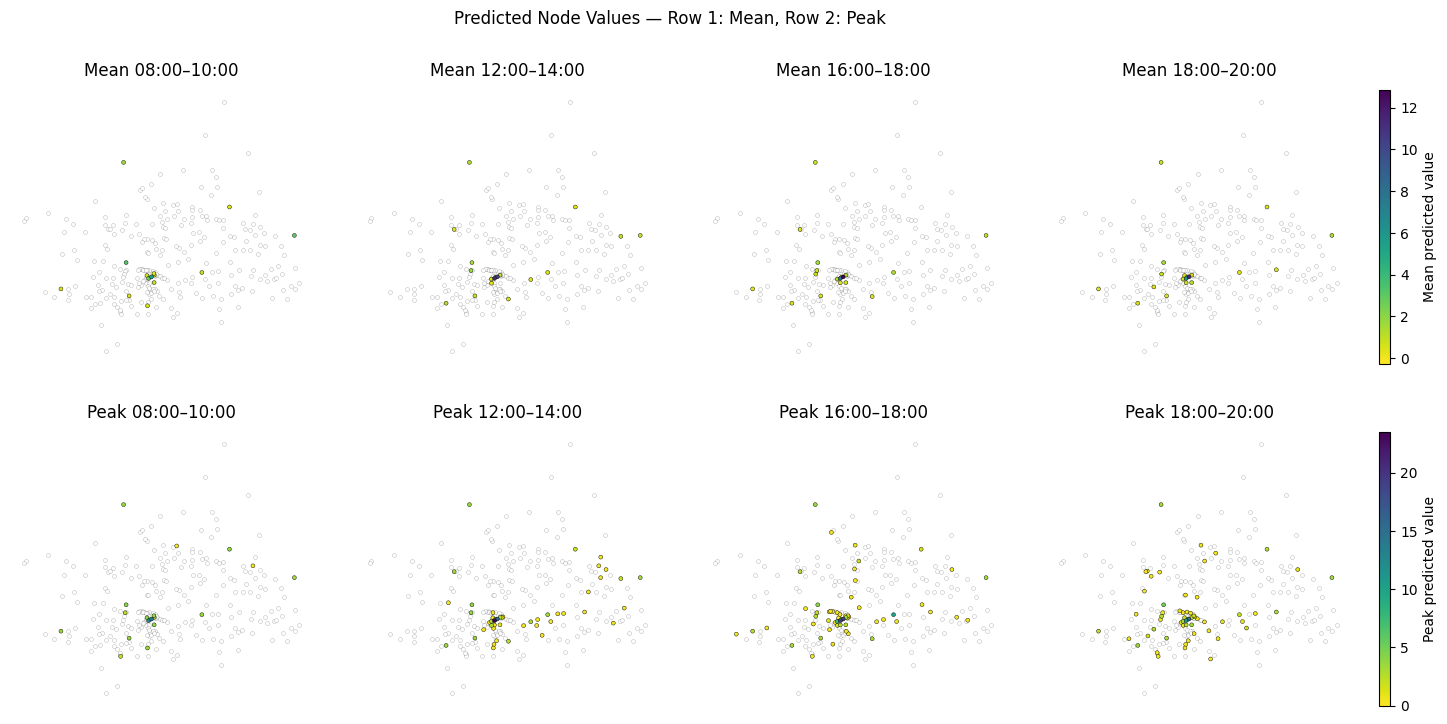

C:\Users\Michele\AppData\Local\Temp\ipykernel_22296\962313267.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location="cpu")
C:\Users\Mi

Interval 08-10: selected bins = 8
Interval 12-14: selected bins = 8
Interval 16-18: selected bins = 8
Interval 18-20: selected bins = 8
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_mean_ge_23C_baseline_mean_08-10_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_mean_ge_23C_baseline_peak_08-10_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_mean_ge_23C_baseline_mean_12-14_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_mean_ge_23C_baseline_peak_12-14_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_mean_ge_23C_baseline_mean_16-18_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_mean_ge_23C_baseline_peak_16-18_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_mean_ge_23C_baseline_mean_18-20_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_mea

C:\Users\Michele\AppData\Local\Temp\ipykernel_22296\1015935249.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.98, 0.94])


Saved figure → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_mean_ge_23C_baseline_grid_subset.png


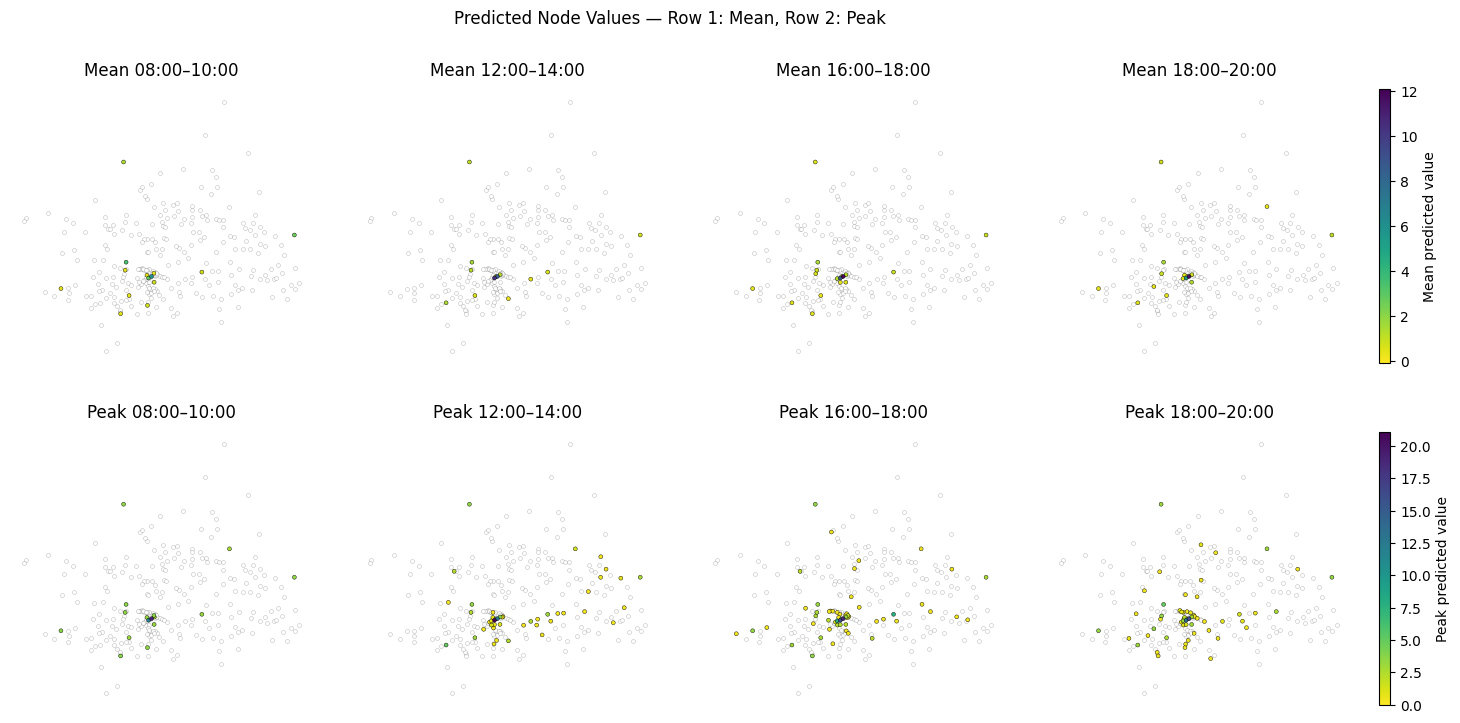

In [182]:
hot_csv = os.path.join(SCENARIO_DIR, "hot_temp_mean_ge_23.0C.csv")
hot_dates = load_scenario_dates(hot_csv)

generate_interval_maps(
    day_selector=hot_dates, 
    weekdays_only=True,
    zero_cutoff=0.3,
    cmap="viridis_r",
    save_prefix="interval_maps_hot_23C_climate",
    ckpt_path=CLIMATE,
    art_path=ART_CLIMATE
)

generate_interval_maps(
    day_selector=hot_dates, 
    weekdays_only=True,
    zero_cutoff=0.3,
    cmap="viridis_r",
    save_prefix="interval_maps_hot_mean_ge_23C_baseline",
    ckpt_path=BASELINE,
    art_path=ART_BASELINE
)

C:\Users\Michele\AppData\Local\Temp\ipykernel_22296\962313267.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location="cpu")
C:\Users\Mi

Interval 08-10: selected bins = 9
Interval 12-14: selected bins = 9
Interval 16-18: selected bins = 9
Interval 18-20: selected bins = 9
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_climate_mean_08-10_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_climate_peak_08-10_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_climate_mean_12-14_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_climate_peak_12-14_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_climate_mean_16-18_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_climate_peak_16-18_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_climate_mean_18-20_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_climate_peak_18-20_subset.csv


C:\Users\Michele\AppData\Local\Temp\ipykernel_22296\1015935249.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.98, 0.94])


Saved figure → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_climate_grid_subset.png


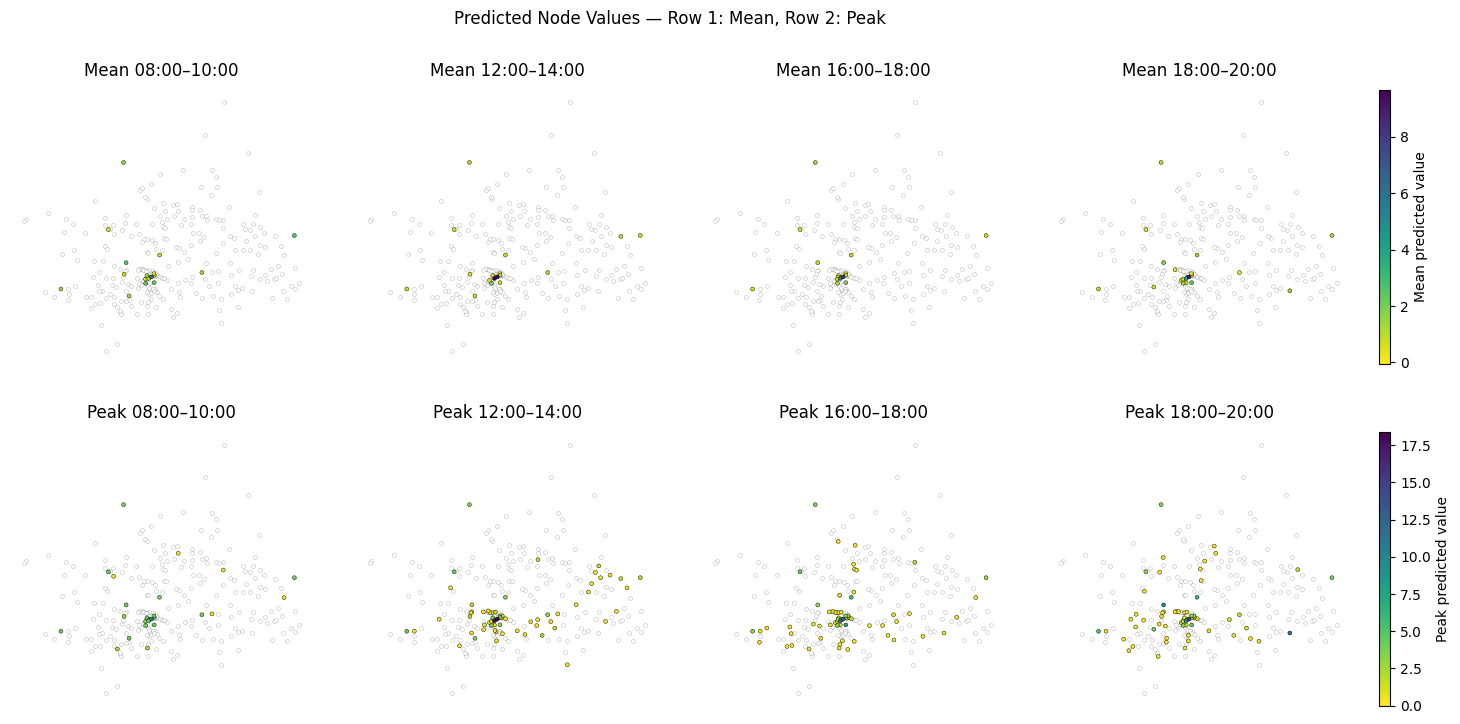

C:\Users\Michele\AppData\Local\Temp\ipykernel_22296\962313267.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location="cpu")
C:\Users\Mi

Interval 08-10: selected bins = 9
Interval 12-14: selected bins = 9
Interval 16-18: selected bins = 9
Interval 18-20: selected bins = 9
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_baseline_mean_08-10_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_baseline_peak_08-10_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_baseline_mean_12-14_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_baseline_peak_12-14_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_baseline_mean_16-18_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_baseline_peak_16-18_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_baseline_mean_18-20_subset.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_baseline_peak_18-20_subset.csv


C:\Users\Michele\AppData\Local\Temp\ipykernel_22296\1015935249.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.98, 0.94])


Saved figure → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_baseline_grid_subset.png


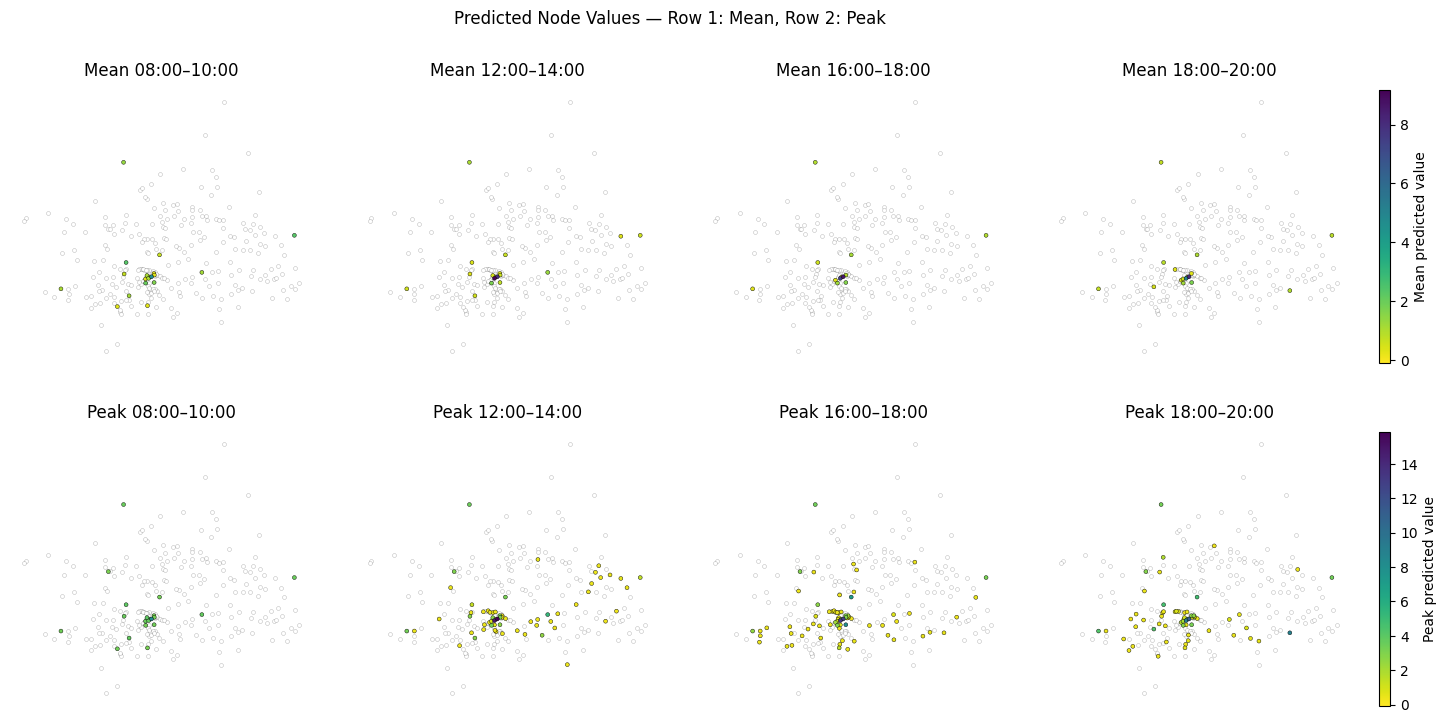

In [183]:
cold_csv = os.path.join(SCENARIO_DIR, "cold_temp_mean_le_10.0C.csv")
cold_dates = load_scenario_dates(cold_csv)

generate_interval_maps(
    day_selector=cold_dates, 
    weekdays_only=True,
    zero_cutoff=0.3,
    cmap="viridis_r",
    save_prefix="interval_maps_cold_10C_climate",
    ckpt_path=CLIMATE,
    art_path=ART_CLIMATE
)

generate_interval_maps(
    day_selector=cold_dates, 
    weekdays_only=True,
    zero_cutoff=0.3,
    cmap="viridis_r",
    save_prefix="interval_maps_cold_10C_baseline",
    ckpt_path=BASELINE,
    art_path=ART_BASELINE
)

C:\Users\Michele\AppData\Local\Temp\ipykernel_22296\1151037442.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location="cpu")
C:\Users\M

Interval 08-10: selected bins = 32
Interval 12-14: selected bins = 32
Interval 16-18: selected bins = 32
Interval 18-20: selected bins = 32
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_full_mean_08-10_alldays.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_full_peak_08-10_alldays.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_full_mean_12-14_alldays.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_full_peak_12-14_alldays.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_full_mean_16-18_alldays.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_full_peak_16-18_alldays.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_full_mean_18-20_alldays.csv
Saved → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_full_peak_18-20_alldays.csv


C:\Users\Michele\AppData\Local\Temp\ipykernel_22296\1015935249.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.98, 0.94])


Saved figure → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_full_grid_alldays.png


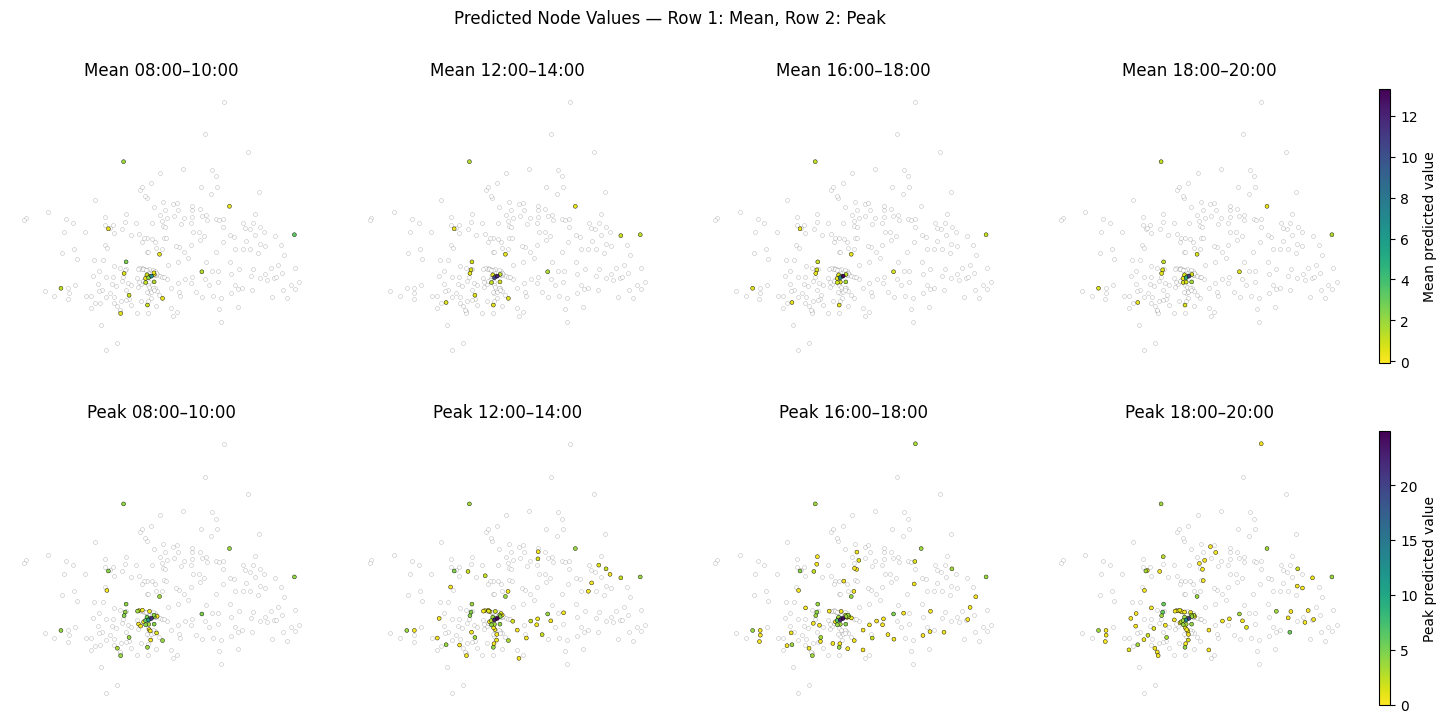

In [ ]:
generate_interval_maps(day_selector=None, 
                       weekdays_only=True, 
                       zero_cutoff=0.3, 
                       cmap="viridis_r",
                       save_prefix="interval_maps_full",
                       ckpt_path=CLIMATE_URBAN,
                       art_path=ART_CLIMATE_URBAN)